In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("SmartMeterForecast")
    .config("spark.driver.memory", "12g")
    .config("spark.executor.memory", "12g")
    .config("spark.driver.cores", "4")
    .config("spark.executor.cores", "4")
    .config("spark.sql.shuffle.partitions", "16")  # Based on 4 allocated cores
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .getOrCreate()
)


In [2]:
base_path = "hdfs://namenode:9000/data/raw/"

In [3]:
daily_df = spark.read.csv(base_path + "daily_dataset.csv", header=True, inferSchema=True)
acorn_df = spark.read.csv(base_path + "acorn_details.csv", header=True, inferSchema=True)
bank_holidays_df = spark.read.csv(base_path + "uk_bank_holidays.csv", header=True, inferSchema=True)
weather_df = spark.read.csv(base_path + "weather_daily_darksky.csv", header=True, inferSchema=True)

In [4]:
daily_df.printSchema()
daily_df.show(5)

root
 |-- LCLid: string (nullable = true)
 |-- day: date (nullable = true)
 |-- energy_median: double (nullable = true)
 |-- energy_mean: double (nullable = true)
 |-- energy_max: double (nullable = true)
 |-- energy_count: integer (nullable = true)
 |-- energy_std: double (nullable = true)
 |-- energy_sum: double (nullable = true)
 |-- energy_min: double (nullable = true)

+---------+----------+-------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|    LCLid|       day|energy_median|        energy_mean|        energy_max|energy_count|         energy_std|        energy_sum|         energy_min|
+---------+----------+-------------+-------------------+------------------+------------+-------------------+------------------+-------------------+
|MAC000131|2011-12-15|        0.485|0.43204545454545457|             0.868|          22|0.23914579678767536|             9.505|0.07200000000000001|
|MAC000131|2011-12-16|       0.

In [ ]:
from pyspark.sql.functions import col, isnan, when, count

def nulls_count(df):
    exprs = []
    for c, dtype in df.dtypes:
        if dtype in ['double', 'float']:
            # For numeric columns, check both null and NaN
            expr = count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
        else:
            # For other types, only check nulls
            expr = count(when(col(c).isNull(), c)).alias(c)
        exprs.append(expr)
    return df.select(exprs).show()

In [ ]:
nulls_count(daily_df)

In [4]:
from pyspark.sql.functions import col, when, lit, sequence, explode
from pyspark.sql import functions as F

# Calculate medians for imputation
median_energy_sum = daily_df.approxQuantile("energy_sum", [0.5], 0.01)[0]
median_energy_mean = daily_df.approxQuantile("energy_mean", [0.5], 0.01)[0]
median_energy_min = daily_df.approxQuantile("energy_min", [0.5], 0.01)[0]
median_energy_max = daily_df.approxQuantile("energy_max", [0.5], 0.01)[0]
median_energy_median = daily_df.approxQuantile("energy_median", [0.5], 0.01)[0]

print(f"Medians calculated:\nenergy_sum={median_energy_sum}, energy_mean={median_energy_mean}")

Medians calculated:
energy_sum=7.791, energy_mean=0.16295833333333334


In [5]:
from pyspark.sql.functions import col, when, lit, sequence, explode
from pyspark.sql import functions as F

daily_df = daily_df \
    .withColumn("energy_sum", when(col("energy_sum").isNull(), median_energy_sum).otherwise(col("energy_sum"))) \
    .withColumn("energy_mean", when(col("energy_mean").isNull(), median_energy_mean).otherwise(col("energy_mean"))) \
    .withColumn("energy_min", when(col("energy_min").isNull(), median_energy_min).otherwise(col("energy_min"))) \
    .withColumn("energy_max", when(col("energy_max").isNull(), median_energy_max).otherwise(col("energy_max"))) \
    .withColumn("energy_median", when(col("energy_median").isNull(), median_energy_median).otherwise(col("energy_median"))) \
    .withColumn("energy_std", when(col("energy_std").isNull(), lit(0)).otherwise(col("energy_std")))

In [6]:
min_date = daily_df.select(F.min("day")).collect()[0][0]
max_date = daily_df.select(F.max("day")).collect()[0][0]

households = daily_df.select("LCLid").distinct()

all_dates = spark.createDataFrame([(min_date, max_date)], ["start", "end"]) \
    .select(explode(sequence(col("start"), col("end"))).alias("day"))

full_panel = households.crossJoin(all_dates)

print(f"Date range from {min_date} to {max_date}")
print(f"Number of households: {households.count()}")
print(f"Full panel size (households × days): {full_panel.count()}")

Date range from 2011-11-23 to 2014-02-28
Number of households: 5566
Full panel size (households × days): 4614214


In [7]:
daily_df = full_panel.join(daily_df, ["LCLid", "day"], "left_outer")

cols_to_fill = ["energy_median", "energy_mean", "energy_max", "energy_count", "energy_std", "energy_sum", "energy_min"]

for c in cols_to_fill:
    daily_df = daily_df.withColumn(c, when(col(c).isNull(), lit(0)).otherwise(col(c)))

In [ ]:
nulls_count(daily_df)

In [8]:
from pyspark.sql.functions import dayofweek, month, year, date_format, expr

daily_df = daily_df \
    .withColumn("weekday", dayofweek("day")) \
    .withColumn("month", month("day")) \
    .withColumn("year", year("day")) \
    .withColumn("is_weekend", expr("weekday in (1,7)").cast("integer"))  # 1=Sunday,7=Saturday in Spark dayofweek

In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

window = Window.partitionBy("LCLid").orderBy("day")
daily_df = daily_df.withColumn("energy_sum_lag1", lag("energy_sum").over(window))
#krfjerbrfjwbfebrjkebvrjkbr

In [8]:
from pyspark.sql.functions import col

for c in ["energy_sum_lag1"]:
    null_count = daily_df.filter(col(c).isNull()).count()
    print(f"Column '{c}' has {null_count} null(s)")
    
# Fill null lag values with 0 or median if needed
daily_df = daily_df.fillna({"energy_sum_lag1": 0})

Column 'energy_sum_lag1' has 5566 null(s)


In [9]:
for c in ["energy_sum_lag1"]:
    null_count = daily_df.filter(col(c).isNull()).count()
    print(f"Column '{c}' has {null_count} null(s)")

Column 'energy_sum_lag1' has 0 null(s)


In [ ]:
daily_df.printSchema()
daily_df.describe(["energy_sum", "energy_sum_lag1"]).show()

In [9]:
from pyspark.sql.functions import col

# Step 1: Filter out rows where energy_sum == 0
daily_filtered_df = daily_df.filter(col("energy_sum") != 0)

# Step 2: Sample 15% of the filtered data (random sample)
daily_df = daily_filtered_df.sample(fraction=0.022, seed=42)

# Optional: cache or persist the sample for repeated use
daily_df = daily_df.cache()

# Check count to confirm
print("Filtered daily_df count:", daily_filtered_df.count())
print("Sampled daily_df count:", daily_df.count())

Filtered daily_df count: 3495295
Sampled daily_df count: 77099


In [10]:
from pyspark.sql.functions import col

zero_count = daily_df.filter(col("energy_sum") == 0).count()
total_count = daily_df.count()
zero_percentage = (zero_count / total_count) * 100

print(f"Zero consumption days: {zero_count}")
print(f"Total days: {total_count}")
print(f"Percentage of zero consumption days: {zero_percentage:.2f}%")

Zero consumption days: 0
Total days: 77099
Percentage of zero consumption days: 0.00%


In [ ]:
daily_df.printSchema()
daily_df.show(5)

In [ ]:
acorn_df.printSchema()
acorn_df.show(5)

In [ ]:
nulls_count(acorn_df)

In [11]:
from pyspark.sql.functions import trim

acorn_df = acorn_df.withColumnRenamed("MAIN CATEGORIES", "main_category") \
                   .withColumnRenamed("CATEGORIES", "category") \
                   .withColumnRenamed("REFERENCE", "reference")

# Trim whitespace in categorical columns
acorn_df = acorn_df.withColumn("main_category", trim(acorn_df.main_category)) \
                   .withColumn("category", trim(acorn_df.category)) \
                   .withColumn("reference", trim(acorn_df.reference))

In [13]:
duplicates_count = acorn_df.groupBy("main_category", "category", "reference") \
    .count() \
    .filter("count > 1") \
    .count()

print(f"Number of duplicate key rows: {duplicates_count}")

Number of duplicate key rows: 0


In [12]:
from pyspark.sql.functions import lit, col, array, struct, explode

# List of ACORN group suffixes
acorn_groups = list("ABCDEFGHIJKLMNOPQ")

# Create list of ACORN column names like 'ACORN-A', 'ACORN-B', ...
acorn_cols = [f"ACORN-{c}" for c in acorn_groups]

# Build array of structs with acorn_group and value
acorn_array = array(*[
    struct(lit(c).alias("acorn_group"), col(f"ACORN-{c}").alias("value")) for c in acorn_groups
])

# Explode the array into rows, transforming wide -> long
acorn_df = acorn_df.withColumn("acorn_struct", acorn_array) \
    .select(
        "main_category", "category", "reference",
        explode("acorn_struct").alias("acorn_struct")
    ) \
    .select(
        "main_category", "category", "reference",
        col("acorn_struct.acorn_group").alias("acorn_group"),
        col("acorn_struct.value").alias("value")
    )

In [ ]:
acorn_df.describe("value").show()

In [ ]:
nulls_count(acorn_df)

In [ ]:
acorn_df.printSchema()
acorn_df.show(5)

In [ ]:
weather_df.printSchema()
weather_df.show(5, truncate=False)

In [13]:
from pyspark.sql.functions import to_date, col

# Drop low-value timestamp columns
cols_to_drop = [
    "temperatureMaxTime", "temperatureMinTime", "apparentTemperatureMinTime", "apparentTemperatureHighTime",
    "apparentTemperatureMaxTime", "apparentTemperatureLowTime", "uvIndexTime", "sunsetTime",
    "sunriseTime", "temperatureHighTime", "temperatureLowTime"
]
weather_df = weather_df.drop(*cols_to_drop)

# Convert timestamp to date for joining
weather_df = weather_df.withColumn("date", to_date(col("time"))).drop("time")

# Fill nulls for important continuous columns
weather_df = weather_df.fillna({
    "cloudCover": 0,
    "uvIndex": 0
})


In [14]:
from pyspark.sql.functions import when

# Create binary precipitation flag
weather_df = weather_df.withColumn(
    "has_precip",
    when(col("precipType").isNotNull(), 1).otherwise(0)
)

# Calculate temperature range and average temperature
weather_df = weather_df.withColumn(
    "temp_range",
    col("temperatureMax") - col("temperatureMin")
).withColumn(
    "temp_avg",
    (col("temperatureMax") + col("temperatureMin")) / 2
)

# Quick checks
weather_df.select("date", "precipType", "has_precip").show(5)
weather_df.select("date", "temperatureMax", "temperatureMin", "temp_range", "temp_avg").show(5)


+----------+----------+----------+
|      date|precipType|has_precip|
+----------+----------+----------+
|2011-11-11|      rain|         1|
|2011-12-11|      rain|         1|
|2011-12-27|      rain|         1|
|2011-12-02|      rain|         1|
|2011-12-24|      rain|         1|
+----------+----------+----------+
only showing top 5 rows

+----------+--------------+--------------+------------------+------------------+
|      date|temperatureMax|temperatureMin|        temp_range|          temp_avg|
+----------+--------------+--------------+------------------+------------------+
|2011-11-11|         11.96|          8.85| 3.110000000000001|10.405000000000001|
|2011-12-11|          8.59|          2.48| 6.109999999999999|             5.535|
|2011-12-27|         10.33|          8.03|2.3000000000000007|              9.18|
|2011-12-02|          8.07|          2.56|              5.51|             5.315|
|2011-12-24|          8.22|          3.17| 5.050000000000001|             5.695|
+----------+

In [15]:
# Calculate temperature range (max - min) and average temperature
weather_df = weather_df.withColumn(
    "temp_range",
    col("temperatureMax") - col("temperatureMin")
).withColumn(
    "temp_avg",
    (col("temperatureMax") + col("temperatureMin")) / 2
)

# Check results
weather_df.select("date", "temperatureMax", "temperatureMin", "temp_range", "temp_avg").show(5)

+----------+--------------+--------------+------------------+------------------+
|      date|temperatureMax|temperatureMin|        temp_range|          temp_avg|
+----------+--------------+--------------+------------------+------------------+
|2011-11-11|         11.96|          8.85| 3.110000000000001|10.405000000000001|
|2011-12-11|          8.59|          2.48| 6.109999999999999|             5.535|
|2011-12-27|         10.33|          8.03|2.3000000000000007|              9.18|
|2011-12-02|          8.07|          2.56|              5.51|             5.315|
|2011-12-24|          8.22|          3.17| 5.050000000000001|             5.695|
+----------+--------------+--------------+------------------+------------------+
only showing top 5 rows



In [17]:
from pyspark.sql.functions import lower, regexp_extract

# Standardize weather icon column to lowercase
weather_df = weather_df.withColumn("weather_condition", lower(col("icon")))

# Extract main weather type (e.g., rain, fog, partly-cloudy-day)
weather_df = weather_df.withColumn(
    "weather_main",
    regexp_extract(col("weather_condition"), r"^[\w-]+", 0)
)

# Show the new weather categories
weather_df.select("date", "icon", "weather_condition", "weather_main").show(10, truncate=False)


+----------+-------------------+-------------------+-------------------+
|date      |icon               |weather_condition  |weather_main       |
+----------+-------------------+-------------------+-------------------+
|2011-11-11|fog                |fog                |fog                |
|2011-12-11|partly-cloudy-day  |partly-cloudy-day  |partly-cloudy-day  |
|2011-12-27|partly-cloudy-day  |partly-cloudy-day  |partly-cloudy-day  |
|2011-12-02|wind               |wind               |wind               |
|2011-12-24|partly-cloudy-night|partly-cloudy-night|partly-cloudy-night|
|2011-12-15|wind               |wind               |wind               |
|2011-11-19|fog                |fog                |fog                |
|2011-11-16|fog                |fog                |fog                |
|2011-12-12|wind               |wind               |wind               |
|2011-11-20|fog                |fog                |fog                |
+----------+-------------------+-------------------

In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Convert string categories to numeric indices
indexer = StringIndexer(inputCol="weather_main", outputCol="weather_main_index", handleInvalid="keep")
weather_df = indexer.fit(weather_df).transform(weather_df)

# One-hot encode the numeric indices into sparse vectors
encoder = OneHotEncoder(inputCols=["weather_main_index"], outputCols=["weather_main_vec"])
weather_df = encoder.fit(weather_df).transform(weather_df)

# Quick check of encoding results
weather_df.select("weather_main", "weather_main_index", "weather_main_vec").show(5, truncate=False)


+-------------------+------------------+----------------+
|weather_main       |weather_main_index|weather_main_vec|
+-------------------+------------------+----------------+
|fog                |2.0               |(6,[2],[1.0])   |
|partly-cloudy-day  |0.0               |(6,[0],[1.0])   |
|partly-cloudy-day  |0.0               |(6,[0],[1.0])   |
|wind               |1.0               |(6,[1],[1.0])   |
|partly-cloudy-night|3.0               |(6,[3],[1.0])   |
+-------------------+------------------+----------------+
only showing top 5 rows



In [19]:
numeric_cols = [
    "temperatureMax", "temperatureMin", "humidity", "windSpeed", "temp_avg", "temp_range", "uvIndex"
]

# Describe statistics to detect outliers
weather_df.select(numeric_cols).describe().show()

# Show extremes (top 5 max and min) for numeric columns
for col_name in numeric_cols:
    print(f"Top 5 highest values in {col_name}:")
    weather_df.select(col_name).orderBy(col_name, ascending=False).show(5)
    print(f"Top 5 lowest values in {col_name}:")
    weather_df.select(col_name).orderBy(col_name).show(5)


+-------+------------------+-----------------+-------------------+-----------------+------------------+------------------+------------------+
|summary|    temperatureMax|   temperatureMin|           humidity|        windSpeed|          temp_avg|        temp_range|           uvIndex|
+-------+------------------+-----------------+-------------------+-----------------+------------------+------------------+------------------+
|  count|               882|              882|                882|              882|               882|               882|               882|
|   mean|13.660113378684809|7.414160997732437| 0.7818707482993198|3.581802721088436|10.537137188208618| 6.245952380952378|2.5396825396825395|
| stddev|  6.18274426621096|4.888851668302406|0.09534817769101166|1.694006940979859|  5.38152454320157|2.9002015370887797|1.8339437638170617|
|    min|             -0.06|            -5.64|               0.43|              0.2|            -1.855|              0.98|               0.0|
|    m

In [20]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Define window spec ordered by date (global)
window_spec = Window.orderBy("date")

# Create lag features for temp_avg and has_precip
weather_df = weather_df.withColumn("temp_avg_lag1", lag("temp_avg").over(window_spec)) \
                       .withColumn("has_precip_lag1", lag("has_precip").over(window_spec))

# Show lagged features for validation
weather_df.select("date", "temp_avg", "temp_avg_lag1", "has_precip", "has_precip_lag1").show(10)


+----------+------------------+------------------+----------+---------------+
|      date|          temp_avg|     temp_avg_lag1|has_precip|has_precip_lag1|
+----------+------------------+------------------+----------+---------------+
|2011-11-01|            12.625|              NULL|         1|           NULL|
|2011-11-02|            12.035|            12.625|         1|              1|
|2011-11-03|              15.1|            12.035|         1|              1|
|2011-11-04|            13.535|              15.1|         1|              1|
|2011-11-05|            12.055|            13.535|         1|              1|
|2011-11-06|10.655000000000001|            12.055|         1|              1|
|2011-11-07|            11.475|10.655000000000001|         1|              1|
|2011-11-08|             10.34|            11.475|         1|              1|
|2011-11-09|             12.55|             10.34|         1|              1|
|2011-11-10|            11.985|             12.55|         1|   

In [23]:
weather_df.count()

882

In [ ]:
weather_df.printSchema()
weather_df.show(5, truncate=False)

In [ ]:
bank_holidays_df.printSchema()
bank_holidays_df.show(5)

In [ ]:
nulls_count(bank_holidays_df)

In [21]:
from pyspark.sql.functions import to_date

bank_holidays_df = bank_holidays_df.withColumn("date", to_date(col("Bank holidays"))).drop("Bank holidays")

bank_holidays_df.printSchema()
bank_holidays_df.show(5)

root
 |-- Type: string (nullable = true)
 |-- date: date (nullable = true)

+--------------------+----------+
|                Type|      date|
+--------------------+----------+
|          Boxing Day|2012-12-26|
|       Christmas Day|2012-12-25|
| Summer bank holiday|2012-08-27|
|Queen?s Diamond J...|2012-05-06|
|Spring bank holid...|2012-04-06|
+--------------------+----------+
only showing top 5 rows



In [22]:
from pyspark.sql.functions import lit

bank_holidays_df = bank_holidays_df.withColumn("is_bank_holiday", lit(1))

bank_holidays_df.show(5)

+--------------------+----------+---------------+
|                Type|      date|is_bank_holiday|
+--------------------+----------+---------------+
|          Boxing Day|2012-12-26|              1|
|       Christmas Day|2012-12-25|              1|
| Summer bank holiday|2012-08-27|              1|
|Queen?s Diamond J...|2012-05-06|              1|
|Spring bank holid...|2012-04-06|              1|
+--------------------+----------+---------------+
only showing top 5 rows



In [23]:
household_acorn_df = spark.read.csv(base_path + "informations_households.csv", header=True, inferSchema=True)

In [ ]:
household_acorn_df.printSchema()
household_acorn_df.show(5)

In [24]:
household_acorn_df = household_acorn_df.select("LCLid", "Acorn", "Acorn_grouped")

In [25]:
from pyspark.sql.functions import substring, col

household_acorn_df = household_acorn_df \
    .withColumn("acorn_group", substring(col("Acorn"), 7, 1)) \
    .select("LCLid", "acorn_group")

In [ ]:
household_acorn_df.printSchema()
household_acorn_df.show(5)

In [26]:
household_acorn_df = household_acorn_df.filter(
    (col("acorn_group").isNotNull()) & (col("acorn_group") != "")
)

In [27]:
# Join daily energy with weather on date/day
master_df = daily_df.join(
    weather_df.select("date", "temp_avg", "temp_range", "has_precip", "weather_main_vec", "temp_avg_lag1", "has_precip_lag1"),
    daily_df.day == weather_df.date,
    how="left"
).drop(weather_df.date)

# Check join result
master_df.select("day", "temp_avg", "temp_range", "has_precip").show(5)


+----------+--------+------------------+----------+
|       day|temp_avg|        temp_range|has_precip|
+----------+--------+------------------+----------+
|2012-10-22|  13.255|1.5899999999999999|         1|
|2013-01-26|   4.965|5.1899999999999995|         1|
|2013-05-27|  10.955|2.3500000000000014|         1|
|2013-07-18|  21.445|             11.65|         1|
|2012-07-30|  15.855| 8.670000000000002|         1|
+----------+--------+------------------+----------+
only showing top 5 rows



In [28]:
# Join master_df with households_df to get acorn_group
master_df = master_df.join(
    household_acorn_df.select("LCLid", "acorn_group"),
    on="LCLid",
    how="left"
)

# Check result
master_df.select("LCLid", "acorn_group").show(5)


+---------+-----------+
|    LCLid|acorn_group|
+---------+-----------+
|MAC004538|          E|
|MAC004707|          E|
|MAC004707|          E|
|MAC001480|          N|
|MAC003086|          N|
+---------+-----------+
only showing top 5 rows



In [29]:
from pyspark.sql import functions as F

# Aggregate ACORN features by averaging the 'value' per group/category/reference
acorn_agg = acorn_df.groupBy("acorn_group", "main_category", "category", "reference") \
                    .agg(F.avg("value").alias("avg_value"))

# Check number of rows and preview
print("ACORN aggregated count:", acorn_agg.count())
acorn_agg.show(5, truncate=False)

ACORN aggregated count: 14042
+-----------+-------------+--------+---------+---------+
|acorn_group|main_category|category|reference|avg_value|
+-----------+-------------+--------+---------+---------+
|J          |POPULATION   |Age     |Age 0-4  |119.0    |
|H          |POPULATION   |Age     |Age 5-17 |106.0    |
|F          |POPULATION   |Age     |Age 25-34|66.0     |
|L          |POPULATION   |Age     |Age 25-34|109.0    |
|F          |POPULATION   |Age     |Age 50-64|126.0    |
+-----------+-------------+--------+---------+---------+
only showing top 5 rows



In [30]:
from pyspark.sql import functions as F

# Aggregate to one row per acorn_group by averaging 'avg_value' across all other dimensions
acorn_group_summary = acorn_agg.groupBy("acorn_group").agg(
    F.avg("avg_value").alias("avg_value_acorn")
)

# Join to master_df on acorn_group (now 1:1 or many:1, no explosion)
master_df = master_df.join(
    acorn_group_summary,
    on="acorn_group",
    how="left"
)

master_df.select("acorn_group", "avg_value_acorn").show(5)

+-----------+-----------------+
|acorn_group|  avg_value_acorn|
+-----------+-----------------+
|          E|117.8947569557524|
|          E|117.8947569557524|
|          E|117.8947569557524|
|          N|79.91237931681677|
|          N|79.91237931681677|
+-----------+-----------------+
only showing top 5 rows



In [31]:
# Join with holidays_df to add is_bank_holiday flag
master_df = master_df.join(
    bank_holidays_df.select("date", "is_bank_holiday"),
    master_df.day == bank_holidays_df.date,
    how="left"
).drop(bank_holidays_df.date)

# Fill null bank holiday with 0 (no holiday)
master_df = master_df.fillna({"is_bank_holiday": 0})

master_df.select("day", "is_bank_holiday").show(5)

+----------+---------------+
|       day|is_bank_holiday|
+----------+---------------+
|2012-10-22|              0|
|2013-01-26|              0|
|2013-05-27|              1|
|2013-07-18|              0|
|2012-07-30|              0|
+----------+---------------+
only showing top 5 rows



In [ ]:
# Convert the first 10 rows of master_df to a pandas DataFrame and display
master_df.limit(10).toPandas()

In [ ]:
nulls_count(master_df)

In [32]:
from pyspark.sql.functions import avg, col, when, lit

# Drop rows with null in acorn_group
master_df = master_df.na.drop(subset=["acorn_group"])

# Impute weather numeric columns with mean
weather_num_cols = ["temp_avg", "temp_range", "has_precip", "temp_avg_lag1", "has_precip_lag1"]
means = master_df.select([avg(col(c)).alias(c) for c in weather_num_cols]).collect()[0].asDict()
for c in weather_num_cols:
    master_df = master_df.withColumn(
        c,
        when(col(c).isNull(), lit(means[c])).otherwise(col(c))
    )

# Fill avg_value_acorn nulls with 0
master_df = master_df.fillna({"avg_value_acorn": 0})

# Fill other numeric energy columns nulls with 0
numeric_fill_zero_cols = ["energy_median", "energy_mean", "energy_max", "energy_count",
                          "energy_std", "energy_sum", "energy_min"]
master_df = master_df.fillna({c: 0 for c in numeric_fill_zero_cols})



In [33]:
master_df = master_df.filter(col("weather_main_vec").isNotNull())

In [34]:
from pyspark.sql.functions import rand

master_df = master_df.orderBy(rand())

In [35]:
# Convert the first 10 rows of master_df to a pandas DataFrame and display
master_df.limit(10).toPandas()

,acorn_group,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,...,year,is_weekend,temp_avg,temp_range,has_precip,weather_main_vec,temp_avg_lag1,has_precip_lag1,avg_value_acorn,is_bank_holiday
0,F,MAC000591,2012-08-14,0.1715,0.140292,0.320,48,0.104398,6.734,0.005,...,2012,0,19.975,5.19,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",20.795,1.0,95.574535,0
1,H,MAC002239,2013-07-15,0.1200,0.133563,0.573,48,0.085404,6.411,0.032,...,2013,0,23.115,12.17,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",23.630,1.0,97.298915,0
2,E,MAC004413,2012-03-24,0.0155,0.017667,0.033,48,0.008101,0.848,0.008,...,2012,1,12.625,12.41,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)",13.110,1.0,117.894757,0
3,L,MAC003535,2014-02-18,0.3580,0.355813,0.997,48,0.189398,17.079,0.074,...,2014,0,7.990,4.28,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",7.780,1.0,93.724209,0
4,E,MAC004909,2013-11-22,0.0800,0.351250,1.371,48,0.387987,16.860,0.027,...,2013,0,5.705,4.37,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",5.515,1.0,117.894757,0
5,H,MAC002749,2013-07-10,0.0865,0.156229,1.329,48,0.223098,7.499,0.059,...,2013,0,16.840,9.70,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",18.275,1.0,97.298915,0
6,M,MAC003563,2013-11-07,0.1760,0.287208,1.339,48,0.307596,13.786,0.076,...,2013,0,11.035,7.33,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",12.090,1.0,91.410277,0
7,E,MAC005367,2012-07-09,0.1605,0.180333,0.544,48,0.118173,8.656,0.043,...,2012,0,15.370,4.18,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",16.190,1.0,117.894757,0
8,Q,MAC004715,2013-05-07,0.0450,0.047021,0.068,48,0.011842,2.257,0.032,...,2013,0,14.070,5.48,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",14.225,1.0,90.855423,0
9,E,MAC000376,2012-07-11,0.1095,0.122250,0.342,48,0.087783,5.868,0.000,...,2012,0,14.355,8.63,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",15.410,1.0,117.894757,0


In [40]:
master_df.count()

78522

In [43]:
from pyspark.sql.functions import to_date, col

master_df = master_df.withColumn("day", to_date(col("day")))

In [44]:
from pyspark.sql import functions as F

num_cols = [
    "energy_sum", "energy_mean", "energy_max", "energy_min", "energy_std",
    "energy_count","avg_value_acorn", "temp_avg", "temp_range"
]

# Summary stats
master_df.select(num_cols).describe().show()


+-------+------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+
|summary|        energy_sum|         energy_mean|        energy_max|         energy_min|         energy_std|      energy_count|   avg_value_acorn|          temp_avg|        temp_range|
+-------+------------------+--------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+
|  count|             78522|               78522|             78522|              78522|              78522|             78522|             78522|             78522|             78522|
|   mean|10.154947479312822| 0.21234467251217895|0.8379457858727482|0.05970224905631476|0.17299575078840074|47.822877664858254|104.75918327957592|11.000741639285796| 6.265593209546366|
| stddev| 9.073990115882385|   0.189542514025809|0.6685557564434691|0.08472

In [45]:
# Frequency of acorn_group
master_df.groupBy("acorn_group").count().orderBy("count", ascending=False).show()

# Frequency of is_bank_holiday
master_df.groupBy("is_bank_holiday").count().show()

# Frequency of is_weekend
master_df.groupBy("is_weekend").count().show()

# Frequency of weekday
master_df.groupBy("weekday").count().orderBy("weekday").show()

# Frequency of month
master_df.groupBy("month").count().orderBy("month").show()


+-----------+-----+
|acorn_group|count|
+-----------+-----+
|          E|22654|
|          Q|12103|
|          F| 9903|
|          H| 6200|
|          L| 4653|
|          D| 4264|
|          G| 2721|
|          K| 2329|
|          A| 2065|
|          N| 2039|
|          C| 2033|
|          P| 1622|
|          M| 1501|
|          J| 1409|
|          O| 1405|
|          I|  654|
|          U|  625|
|          B|  342|
+-----------+-----+

+---------------+-----+
|is_bank_holiday|count|
+---------------+-----+
|              1| 1860|
|              0|76662|
+---------------+-----+

+----------+-----+
|is_weekend|count|
+----------+-----+
|         1|22122|
|         0|56400|
+----------+-----+

+-------+-----+
|weekday|count|
+-------+-----+
|      1|11095|
|      2|11295|
|      3|11201|
|      4|11358|
|      5|11290|
|      6|11256|
|      7|11027|
+-------+-----+

+-----+-----+
|month|count|
+-----+-----+
|    1| 7796|
|    2| 6961|
|    3| 4678|
|    4| 4682|
|    5| 5810|
|    6| 61

In [46]:
# Average energy_sum by acorn_group
master_df.groupBy("acorn_group") \
    .agg(F.avg("energy_sum").alias("avg_energy_sum")) \
    .orderBy("avg_energy_sum", ascending=False).show()

# Average energy_sum by is_bank_holiday
master_df.groupBy("is_bank_holiday") \
    .agg(F.avg("energy_sum").alias("avg_energy_sum")) \
    .show()

# Average energy_sum by is_weekend
master_df.groupBy("is_weekend") \
    .agg(F.avg("energy_sum").alias("avg_energy_sum")) \
    .show()


+-----------+------------------+
|acorn_group|    avg_energy_sum|
+-----------+------------------+
|          A| 18.76508183907988|
|          D|13.553918386585359|
|          C| 12.05639449045745|
|          B|11.664491225146206|
|          U| 11.56539200272001|
|          J|11.556860181760134|
|          H|11.042550321919357|
|          E|10.436626643996679|
|          K|10.234146414899072|
|          M|10.125196534377064|
|          L|10.094718675757598|
|          G|10.028034913855238|
|          N| 9.406888181020117|
|          I|  9.35455810382263|
|          F| 9.084198323306078|
|          O|  8.54490106640571|
|          Q| 7.608679830769218|
|          P| 6.962332924475951|
+-----------+------------------+

+---------------+------------------+
|is_bank_holiday|    avg_energy_sum|
+---------------+------------------+
|              1|10.501762365215056|
|              0|10.146532936413083|
+---------------+------------------+

+----------+------------------+
|is_weekend|    av

In [37]:
master_df = master_df.toPandas()

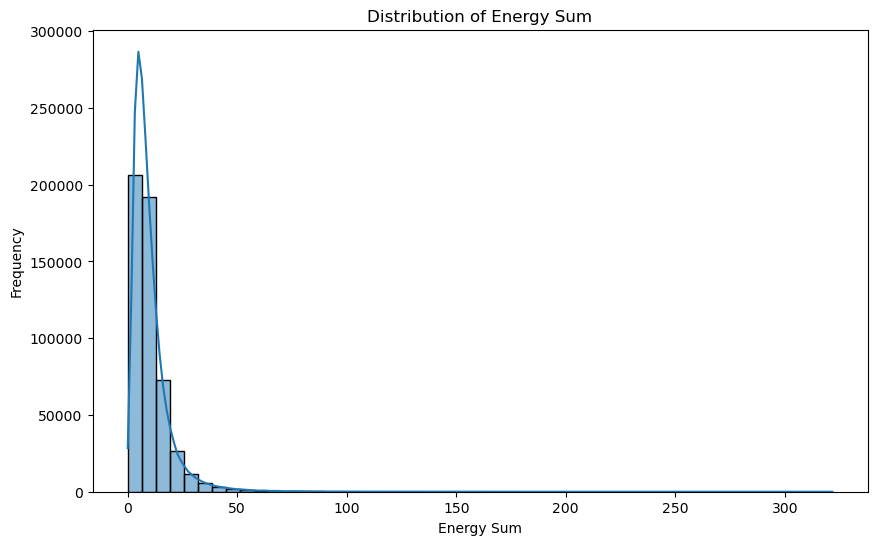

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(master_df["energy_sum"], bins=50, kde=True)
plt.title("Distribution of Energy Sum")
plt.xlabel("Energy Sum")
plt.ylabel("Frequency")
plt.show()

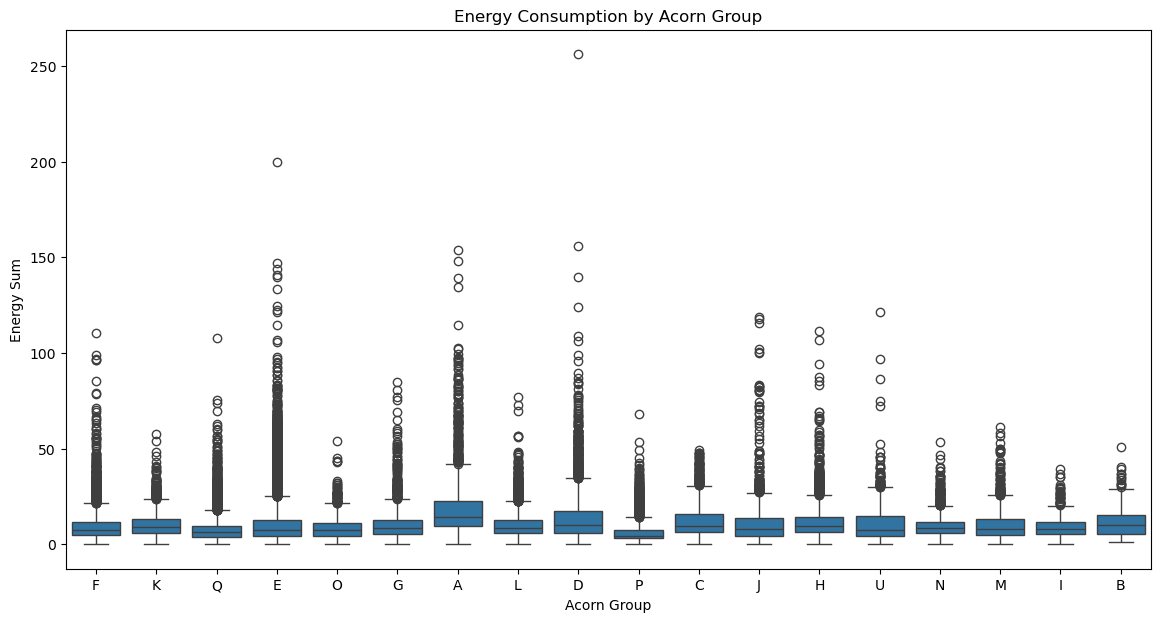

In [50]:
plt.figure(figsize=(14,7))
sns.boxplot(x="acorn_group", y="energy_sum", data=master_df)
plt.title("Energy Consumption by Acorn Group")
plt.xlabel("Acorn Group")
plt.ylabel("Energy Sum")
plt.show()

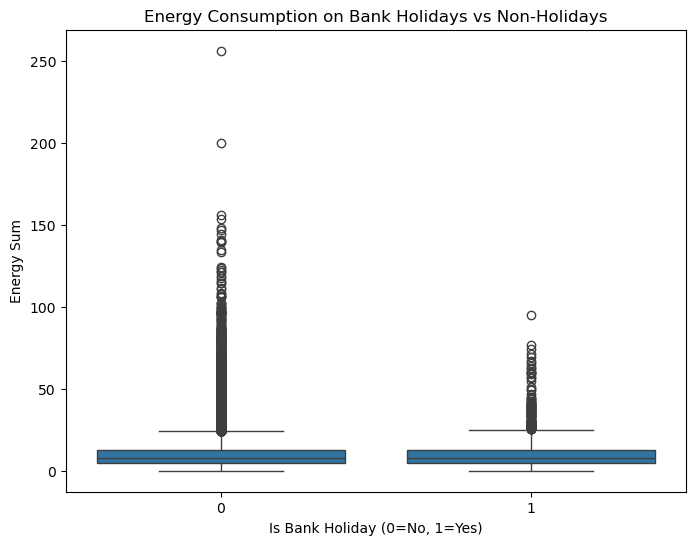

In [51]:
plt.figure(figsize=(8,6))
sns.boxplot(x="is_bank_holiday", y="energy_sum", data=master_df)
plt.title("Energy Consumption on Bank Holidays vs Non-Holidays")
plt.xlabel("Is Bank Holiday (0=No, 1=Yes)")
plt.ylabel("Energy Sum")
plt.show()

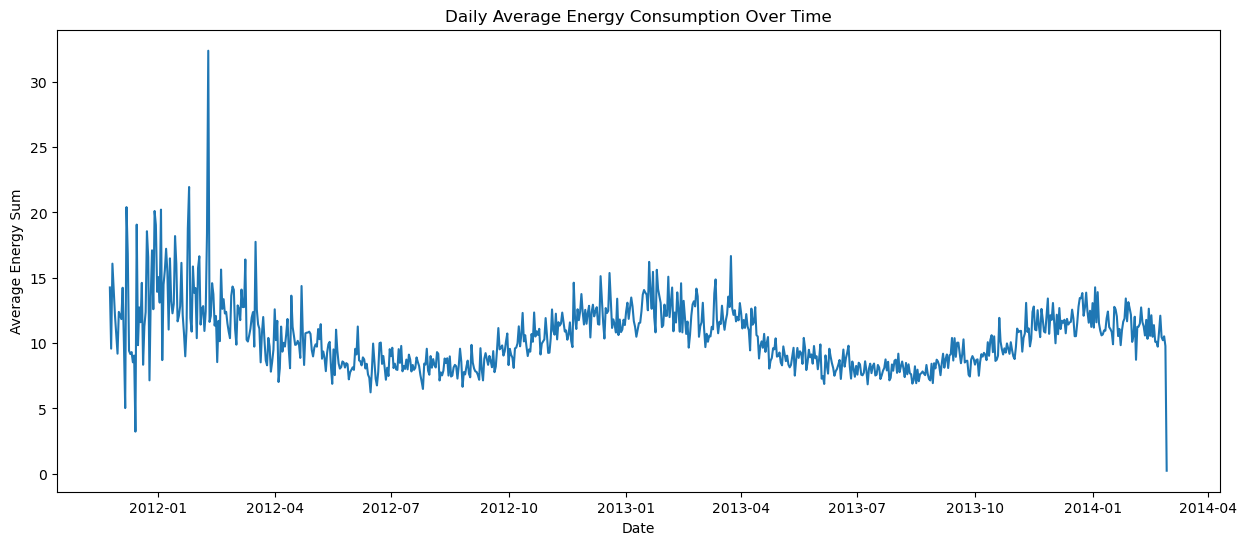

In [52]:
daily_avg = master_df.groupby('day')['energy_sum'].mean().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(x='day', y='energy_sum', data=daily_avg)
plt.title("Daily Average Energy Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Average Energy Sum")
plt.show()

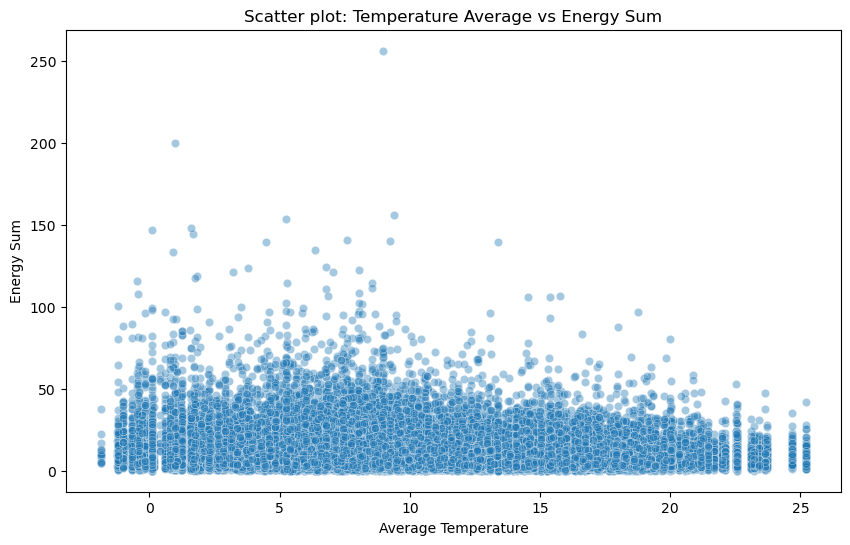

In [53]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="temp_avg", y="energy_sum", data=master_df, alpha=0.4)
plt.title("Scatter plot: Temperature Average vs Energy Sum")
plt.xlabel("Average Temperature")
plt.ylabel("Energy Sum")
plt.show()

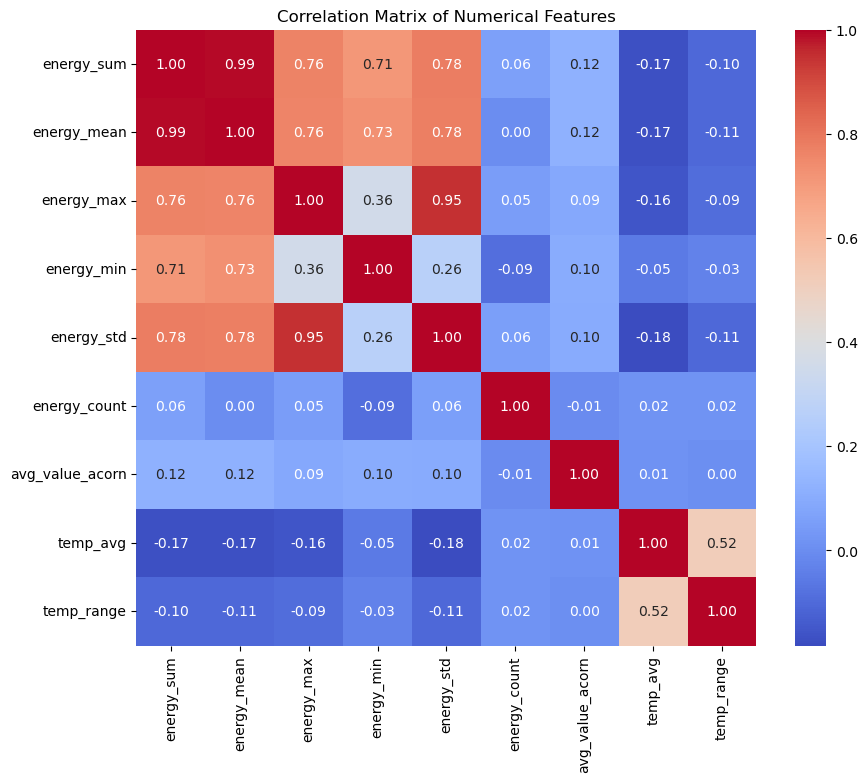

In [54]:
corr_matrix = master_df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [40]:
spark_df = spark.createDataFrame(master_df)

In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# 1. Prepare features and target

feature_cols = [c for c in master_df.columns if c not in ('energy_sum', 'energy_median', 'energy_mean', 'LCLid', 'day', 'acorn_group')]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(master_df).select("features", col("energy_sum").alias("label"))

# 2. Split data

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# 3. Define models

lr = LinearRegression(featuresCol="features", labelCol="label")
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=50)
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)

models = {
    "Linear Regression": lr,
    "Random Forest": rf,
    "Gradient Boosted Trees": gbt
}

# 4. Define evaluator

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# 5. Train, predict, evaluate

for name, model in models.items():
    print(f"\nTraining {name}...")
    fitted_model = model.fit(train_data)
    
    # Evaluate on train data
    train_pred = fitted_model.transform(train_data)
    train_rmse = evaluator_rmse.evaluate(train_pred)
    train_r2 = evaluator_r2.evaluate(train_pred)
    
    # Evaluate on test data
    test_pred = fitted_model.transform(test_data)
    test_rmse = evaluator_rmse.evaluate(test_pred)
    test_r2 = evaluator_r2.evaluate(test_pred)
    
    print(f"{name} Performance:")
    print(f"  Train RMSE: {train_rmse:.4f}, Train R2: {train_r2:.4f}")
    print(f"  Test  RMSE: {test_rmse:.4f}, Test  R2: {test_r2:.4f}")



Training Linear Regression...
Linear Regression Performance:
  Train RMSE: 2.6822, Train R2: 0.9071
  Test  RMSE: 2.7649, Test  R2: 0.9039

Training Random Forest...
Random Forest Performance:
  Train RMSE: 3.9523, Train R2: 0.8128
  Test  RMSE: 3.9043, Test  R2: 0.7935

Training Gradient Boosted Trees...
Gradient Boosted Trees Performance:
  Train RMSE: 2.9064, Train R2: 0.8934
  Test  RMSE: 2.9141, Test  R2: 0.8916
